#Semgetiation of Chest X-ays#

Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
from glob import glob
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

Visualizing the images and masks

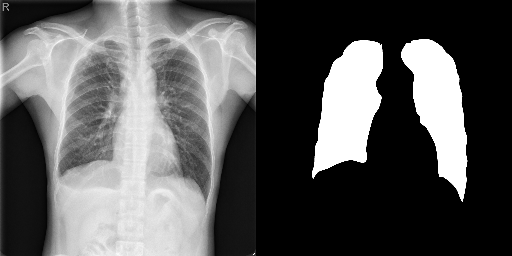

In [ ]:
images = sorted(glob('/content/drive/MyDrive/CXR_project/For Project/Segmentation/Training Data/images/*'))
masks = sorted(glob('/content/drive/MyDrive/CXR_project/For Project/Segmentation/Training Data/maska/*'))
idx = random.randint(0, len(images) - 1)
im = cv.imread(images[idx])
ma = cv.imread(masks[idx])

im = cv.resize(im, (256,256))
ma = cv.resize(ma, (256,256))
imma = np.concatenate((im, ma), axis=1)
cv2_imshow(imma)

Nomralizing the images and masks

In [ ]:
imlist = []
masklist = []
for image_name, mask_name in zip(images, masks):
  image = cv.resize(cv.imread(image_name), (512,512))
  mask = cv.resize(cv.imread(mask_name, 0), (512,512))

  image = image/255.0
  mask = mask/255.0
  mask = mask > 0.5
  imlist.append(image)
  masklist.append(mask)


In [ ]:
imlist = np.array(imlist)
masklist = np.array(masklist)

In [ ]:
print(imlist.shape)
masklist.shape

(762, 512, 512, 3)


(762, 512, 512)

###Defining the architecture###

In [ ]:
def conv(inputs, filters, pool = True):
  #conv conv maxpool
  c = Conv2D(filters, 3, padding = "same")(inputs)
  c = Dropout(0.25)(c)
  c = Activation("relu")(c)

  c = Conv2D(filters, 3, padding = "same")(inputs)
  c = Dropout(0.25)(c)
  c = Activation("relu")(c)



  if pool == True:
    p = MaxPooling2D(pool_size=(2, 2))(c)
    return c, p
  else:
    return c

def u_net():
  #encoder (going down)
  inputs = Input((512,512,3))

  c1, pool1 = conv(inputs, 32)
  c2, pool2 = conv(pool1, 64)
  c3, pool3 = conv(pool2, 128)

  ## turning back up
  bridge = conv(pool3, 256, pool = False)

  # decode (going up)
  u1 = UpSampling2D((2,2), interpolation = "bilinear")(bridge)
  con = Concatenate()([u1, c3])
  c4 = conv(con, 128, pool = False)

  u2 = UpSampling2D((2,2), interpolation = "bilinear")(c4)
  con = Concatenate()([u2, c2])
  c5 = conv(con, 64, pool = False)

  u3 = UpSampling2D((2,2), interpolation = "bilinear")(c5)
  con = Concatenate()([u3, c1])
  c6 = conv(con, 32, pool = False)

 

  # output layer
  output = Conv2D(1, 1, padding = "same", activation = "sigmoid")(c6)
  return Model(inputs, output)

model = u_net()
model.compile(optimizer=Adam(lr=1e-4), loss=[BinaryCrossentropy(), BinaryCrossentropy()],
                 loss_weights=[0.5,0.5], metrics=['binary_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 512, 512, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_15 (Dropout)           (None, 512, 512, 32  0           ['conv2d_16[0][0]']              
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Defining Callbacks

In [ ]:
Path = '/content/drive/MyDrive/CXR_project/model/'
saveCheckpoints = tf.keras.callbacks.ModelCheckpoint(Path, monitor= 'val_loss', save_best_only=True, save_freq='epoch')
    
callback = [saveCheckpoints, ]

###Training###

In [ ]:
epochs = 15

print('Training...')
model_history = model.fit(x=imlist, y=masklist, epochs=epochs, callbacks = callback,verbose = 1 ,validation_split = 0.2, batch_size = 4)


Training...
Epoch 1/15
153/153 [==============================] - ETA: 0s - loss: 0.2403 - binary_accuracy: 0.7457

153/153 [==============================] - 57s 291ms/step - loss: 0.2403 - binary_accuracy: 0.7457 - val_loss: 0.2432 - val_binary_accuracy: 0.8187
Epoch 2/15
153/153 [==============================] - 38s 246ms/step - loss: 0.1298 - binary_accuracy: 0.9015 - val_loss: 0.3098 - val_binary_accuracy: 0.7031
Epoch 3/15
153/153 [==============================] - 37s 242ms/step - loss: 0.1119 - binary_accuracy: 0.9147 - val_loss: 0.2928 - val_binary_accuracy: 0.7083
Epoch 4/15
153/153 [==============================] - ETA: 0s - loss: 0.1061 - binary_accuracy: 0.9191

153/153 [==============================] - 40s 262ms/step - loss: 0.1061 - binary_accuracy: 0.9191 - val_loss: 0.2194 - val_binary_accuracy: 0.7876
Epoch 5/15
153/153 [==============================] - 37s 245ms/step - loss: 0.1006 - binary_accuracy: 0.9232 - val_loss: 0.2953 - val_binary_accuracy: 0.5985
Epoch 6/15
153/153 [==============================] - ETA: 0s - loss: 0.0952 - binary_accuracy: 0.9271

153/153 [==============================] - 40s 260ms/step - loss: 0.0952 - binary_accuracy: 0.9271 - val_loss: 0.1640 - val_binary_accuracy: 0.8590
Epoch 7/15
153/153 [==============================] - ETA: 0s - loss: 0.0878 - binary_accuracy: 0.9320

153/153 [==============================] - 40s 261ms/step - loss: 0.0878 - binary_accuracy: 0.9320 - val_loss: 0.1552 - val_binary_accuracy: 0.8768
Epoch 8/15
153/153 [==============================] - 38s 247ms/step - loss: 0.0804 - binary_accuracy: 0.9380 - val_loss: 0.2293 - val_binary_accuracy: 0.8121
Epoch 9/15
153/153 [==============================] - ETA: 0s - loss: 0.0743 - binary_accuracy: 0.9437

153/153 [==============================] - 40s 262ms/step - loss: 0.0743 - binary_accuracy: 0.9437 - val_loss: 0.1037 - val_binary_accuracy: 0.9286
Epoch 10/15
153/153 [==============================] - ETA: 0s - loss: 0.0657 - binary_accuracy: 0.9511

153/153 [==============================] - 40s 261ms/step - loss: 0.0657 - binary_accuracy: 0.9511 - val_loss: 0.0805 - val_binary_accuracy: 0.9408
Epoch 11/15
153/153 [==============================] - 38s 247ms/step - loss: 0.0625 - binary_accuracy: 0.9539 - val_loss: 0.0996 - val_binary_accuracy: 0.9287
Epoch 12/15
153/153 [==============================] - 38s 246ms/step - loss: 0.0579 - binary_accuracy: 0.9579 - val_loss: 0.0812 - val_binary_accuracy: 0.9370
Epoch 13/15
153/153 [==============================] - ETA: 0s - loss: 0.0535 - binary_accuracy: 0.9616

153/153 [==============================] - 40s 263ms/step - loss: 0.0535 - binary_accuracy: 0.9616 - val_loss: 0.0727 - val_binary_accuracy: 0.9432
Epoch 14/15
153/153 [==============================] - 37s 244ms/step - loss: 0.0543 - binary_accuracy: 0.9608 - val_loss: 0.0785 - val_binary_accuracy: 0.9394
Epoch 15/15
153/153 [==============================] - 37s 245ms/step - loss: 0.0509 - binary_accuracy: 0.9633 - val_loss: 0.0792 - val_binary_accuracy: 0.9408


Save model for later.

In [ ]:
model.save('/content/drive/MyDrive/CXR_project/model/best.h5')

Load model if necessary.

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/CXR_project/model/best.h5')

###Visualizing the training history###

In [ ]:
model_history.history

{'loss': [0.24028654396533966,
  0.1298278272151947,
  0.11187663674354553,
  0.10609520226716995,
  0.10055562853813171,
  0.09520119428634644,
  0.08776343613862991,
  0.08042579889297485,
  0.07431534677743912,
  0.06573676317930222,
  0.0625191405415535,
  0.057858165353536606,
  0.053474124521017075,
  0.054317448288202286,
  0.050943098962306976],
 'binary_accuracy': [0.745658278465271,
  0.9015307426452637,
  0.9147357940673828,
  0.9191219806671143,
  0.9231757521629333,
  0.9271370768547058,
  0.9320412278175354,
  0.938004195690155,
  0.9437187910079956,
  0.95110684633255,
  0.9538940191268921,
  0.9579010009765625,
  0.9615926742553711,
  0.9607842564582825,
  0.9633015394210815],
 'val_loss': [0.24315588176250458,
  0.3097533881664276,
  0.29276788234710693,
  0.21941572427749634,
  0.29532769322395325,
  0.164046972990036,
  0.1552017629146576,
  0.22928020358085632,
  0.10367560386657715,
  0.0805283933877945,
  0.09963821619749069,
  0.08120178431272507,
  0.07269384711

In [ ]:
np.save('/content/drive/MyDrive/CXR_project/model/model_history.npy',model_history.history )

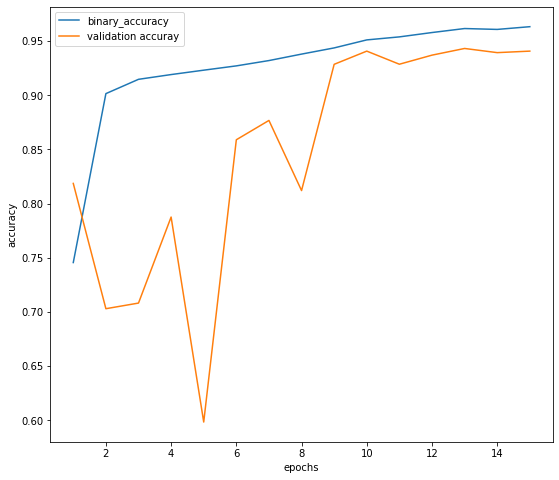

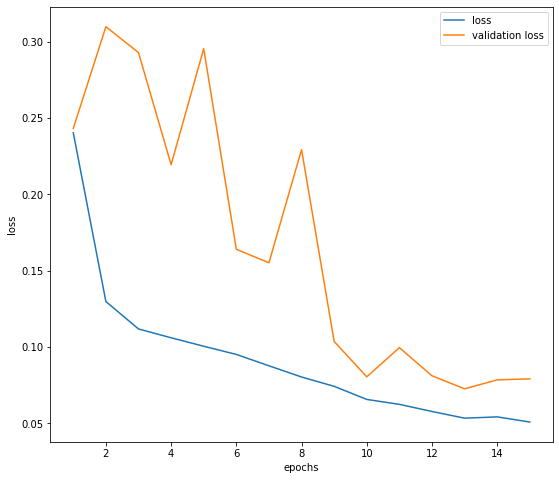

In [ ]:
import matplotlib.pyplot as plt

# saving data from training history for 15 epochs
accuracy = model_history.history['binary_accuracy']
val_accuracy = model_history.history['val_binary_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

#making a list of number of epochs
epochs = list(range(1,len(accuracy) + 1))


plt.plot(epochs,accuracy , label = 'binary_accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuray')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 8)
plt.savefig('/content/drive/MyDrive/CXR_project/metrics/accuracy_epoch.png', bbox_inches='tight')
plt.show()

plt.plot(epochs,loss , label = 'loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 8)
plt.savefig('/content/drive/MyDrive/CXR_project/metrics/loss_epoch.png', bbox_inches='tight')
plt.show()

###Inference###

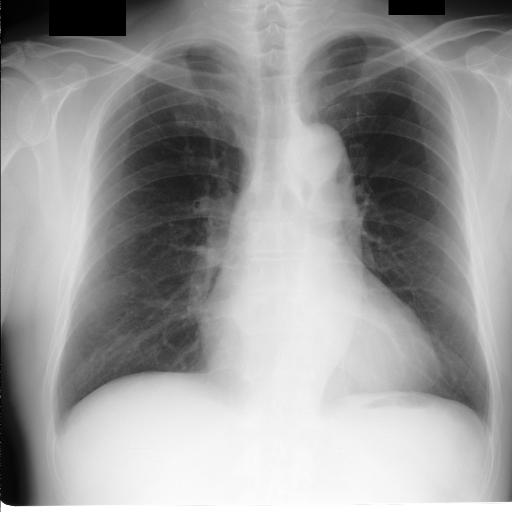

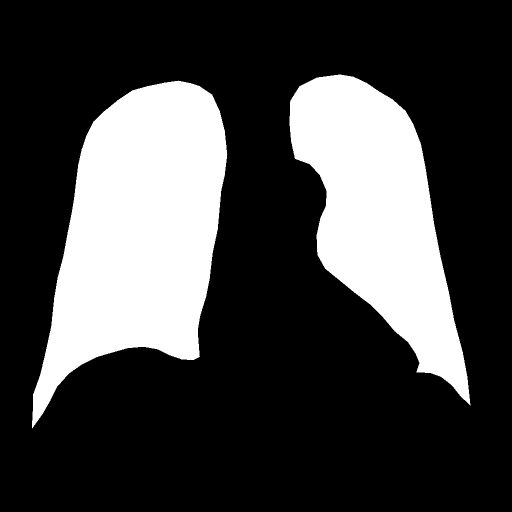

(1, 512, 512, 3)
1/1 [==============================] - 0s 23ms/step


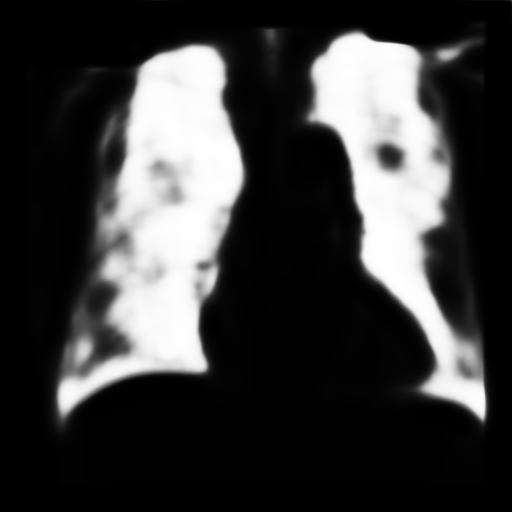

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import tensorflow as tf

SAVE_PATH = '/content/drive/MyDrive/CXR_project/'
#getting all validation images
val_images = glob('/content/drive/MyDrive/CXR_project/For Project/Segmentation/Validation Data/images/*')
val_masks = glob('/content/drive/MyDrive/CXR_project/For Project/Segmentation/Validation Data/masks/*')

#selecting a random image and mask
i = random.randint(0, len(val_images) - 1)
im = cv.resize(cv.imread(val_images[i]),(512,512))
mask = cv.resize(cv.imread(val_masks[i]),(512,512))

cv2_imshow(im)
cv2_imshow(mask)
#normalizing
img = im/255.0

#expand dimensions
img = np.expand_dims(img, axis = 0)
print(img.shape)

#predicting the mask for this image
pred = model.predict(img)
pred = np.squeeze(pred, axis=-1)

pred = pred*255
pred = pred.astype(np.int32)[0]

# showing the result
cv2_imshow(pred)


# Classification of Chest X-rays

###Importing Data###

In [ ]:
x = []
y = []
classes = glob("/content/drive/MyDrive/CXR_project/For Project/Classification/Training/*")

for i in range(len(classes)):
  yTemp = np.zeros(len(classes), dtype = np.float32)
  yTemp[i] = 1.0
  allNames = glob(classes[i] + '/*')
  for name in allNames:
    img = cv.resize(cv.imread(name, 0), (176,176)).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis = -1)
    x.append(img)
    y.append(yTemp)

x = np.array(x)
y = np.array(y)
print(y.shape)

np.save("/content/drive/MyDrive/CXR_project/classification/train_class_image.npy", x)
np.save("/content/drive/MyDrive/CXR_project/classification/train_class_label.npy", y)



(1500, 6)


###Building the architecture###

In [ ]:
def classificationModel(input_size, classes):
  inputs = Input(input_size)

  c1 = Conv2D(64, 3, padding = "same")(inputs)
  c1 = Dropout(0.25)(c1)
  c1 = Activation("relu")(c1)

  c2 = Conv2D(128, 3, padding = "same")(c1)
  c2 = Dropout(0.25)(c2)
  c2 = Activation("relu")(c2)

  p1 = MaxPooling2D()(c2)

  c3 = Conv2D(128, 3, padding = "same")(p1)
  c3 = Dropout(0.25)(c3)
  c3 = Activation("relu")(c3)

  c4 = Conv2D(128, 3, padding = "same")(c3)
  c4 = Dropout(0.25)(c4)
  c4 = Activation("relu")(c4)

  p2 = MaxPooling2D()(c4)

  f = Flatten()(p2)

  d1 = Dense(128, activation="relu")(f)
  outputs = Dense(classes, activation="softmax")(d1)
  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=Adam(lr=1e-4), loss=['categorical_crossentropy'],
                 loss_weights=[0.5,0.5], metrics=['categorical_accuracy'])
  return model

model = classificationModel((176, 176, 1), len(classes))
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 176, 176, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 176, 176, 64)      640       
                                                                 
 dropout_6 (Dropout)         (None, 176, 176, 64)      0         
                                                                 
 activation_6 (Activation)   (None, 176, 176, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 128)     73856     
                                                                 
 dropout_7 (Dropout)         (None, 176, 176, 128)     0         
                                                                 
 activation_7 (Activation)   (None, 176, 176, 128)     0   

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
epochs = 20

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CXR_project/classification/best_save_model.h5", save_best_only = True),
]
classification_model = model.fit(
    x = x, y = y, epochs=epochs, callbacks=callbacks, validation_split=0.1
)



Epoch 1/20
43/43 [==============================] - 15s 358ms/step - loss: 0.1544 - categorical_accuracy: 0.8163 - val_loss: 1.0804 - val_categorical_accuracy: 0.2933
Epoch 2/20
43/43 [==============================] - 13s 294ms/step - loss: 0.1564 - categorical_accuracy: 0.8259 - val_loss: 0.9683 - val_categorical_accuracy: 0.3000
Epoch 3/20
43/43 [==============================] - 11s 266ms/step - loss: 0.1617 - categorical_accuracy: 0.8170 - val_loss: 1.0029 - val_categorical_accuracy: 0.3133
Epoch 4/20
43/43 [==============================] - 12s 268ms/step - loss: 0.1556 - categorical_accuracy: 0.8222 - val_loss: 1.0458 - val_categorical_accuracy: 0.2733
Epoch 5/20
43/43 [==============================] - 15s 342ms/step - loss: 0.1553 - categorical_accuracy: 0.8274 - val_loss: 0.9399 - val_categorical_accuracy: 0.3533
Epoch 6/20
43/43 [==============================] - 11s 263ms/step - loss: 0.1518 - categorical_accuracy: 0.8289 - val_loss: 1.1484 - val_categorical_accuracy: 0.260

###Save model for later use

In [ ]:
model.save('/content/drive/MyDrive/CXR_project/classification/classification_model.h5')

Load if necessary


In [32]:
classification_model =  tf.keras.models.load_model('/content/drive/MyDrive/CXR_project/classification/classification_model.h5')

###Visualizing the training history

Training history

In [ ]:
classification_model.history

{'loss': [0.15436869859695435,
  0.15643201768398285,
  0.16169752180576324,
  0.15558207035064697,
  0.15534886717796326,
  0.1518125683069229,
  0.15672698616981506,
  0.15338507294654846,
  0.15585166215896606,
  0.1527952253818512,
  0.1609254777431488,
  0.15391390025615692,
  0.15015290677547455,
  0.15448637306690216,
  0.15134559571743011,
  0.1514551341533661,
  0.14847959578037262,
  0.14900189638137817,
  0.1486658900976181,
  0.16119490563869476],
 'categorical_accuracy': [0.8162962794303894,
  0.8259259462356567,
  0.817037045955658,
  0.8222222328186035,
  0.8274074196815491,
  0.8288888931274414,
  0.8162962794303894,
  0.8103703856468201,
  0.8192592859268188,
  0.8148148059844971,
  0.821481466293335,
  0.8303703665733337,
  0.8177777528762817,
  0.8222222328186035,
  0.8251851797103882,
  0.8103703856468201,
  0.8125925660133362,
  0.8244444727897644,
  0.838518500328064,
  0.8318518400192261],
 'val_loss': [1.0804256200790405,
  0.9682653546333313,
  1.00292730331420

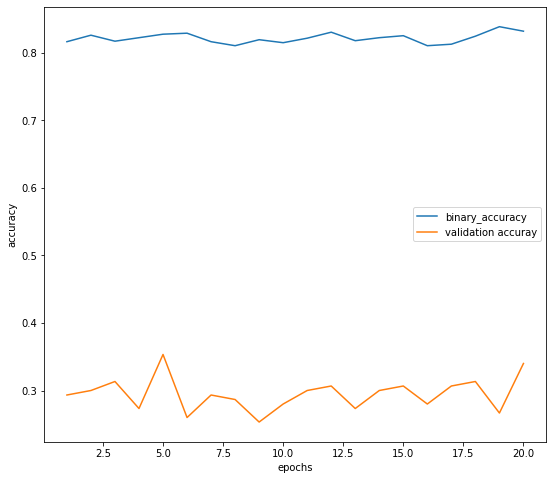

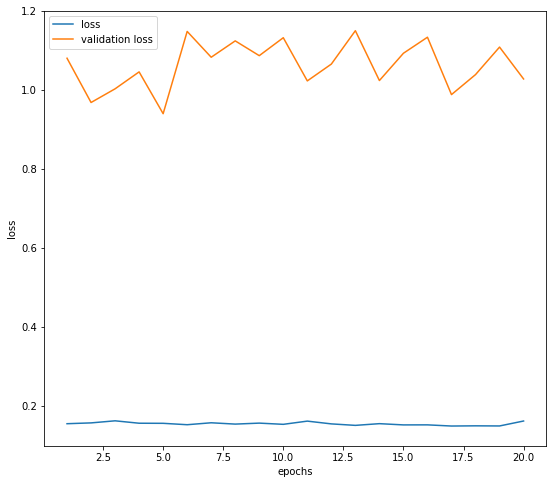

In [ ]:
import matplotlib.pyplot as plt

# saving data from training history for 15 epochs
accuracy = classification_model.history['categorical_accuracy']
val_accuracy = classification_model.history['val_categorical_accuracy']
loss = classification_model.history['loss']
val_loss = classification_model.history['val_loss']

#making a list of number of epochs
epochs = list(range(1,len(accuracy) + 1))


plt.plot(epochs,accuracy , label = 'binary_accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuray')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 8)
plt.savefig('/content/drive/MyDrive/CXR_project/metrics/accuracy_epoch_classification.png', bbox_inches='tight')
plt.show()

plt.plot(epochs,loss , label = 'loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 8)
plt.savefig('/content/drive/MyDrive/CXR_project/metrics/loss_epoch_classification.png', bbox_inches='tight')
plt.show()

###Prediction using model

10. PLEURAL EFFUSION


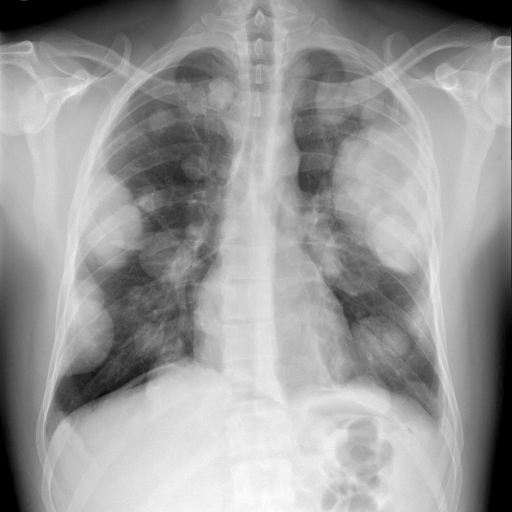

1/1 [==============================] - 0s 183ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.5791558e-22]]


'Pleural effusion'

In [60]:
from google.colab.patches import cv2_imshow
import os
import random

class_test =  random.choice(os.listdir('/content/drive/MyDrive/CXR_project/For Project/Classification/Validation/'))
print(class_test)
path = '/content/drive/MyDrive/CXR_project/For Project/Classification/Validation/' + class_test
images = glob(path + '/*')
test_image = cv.imread(random.choice(images), 0)
cv2_imshow(cv.resize(test_image, (512,512)))
test_image = cv.resize(test_image, (176,176))
test_image = np.expand_dims(np.expand_dims(test_image, axis = -1), axis = 0)
out = classification_model.predict(test_image)
display_labels=['Atelectasis', 'Pleural effusion','consoludation' ,'Cardiomegaly','edema', 'none']
print(out)
display_labels[np.argmax(out)]

### Checking Accuracy ###

In [16]:
val_x = []
val_y = []
val_classes = glob('/content/drive/MyDrive/CXR_project/For Project/Classification/Validation/*')

In [17]:
for i in range(len(val_classes)):
  val_yTemp = np.zeros(len(val_classes), dtype = np.float32)
  val_yTemp[i] = 1.0
  allNames = glob(val_classes[i] + '/*')
  for name in allNames:
    img = cv.resize(cv.imread(name, 0), (176,176)).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis = -1)
    val_x.append(img)
    val_y.append(val_yTemp)

val_x = np.array(val_x)
val_y = np.array(val_y)


In [10]:
print(val_y.shape)

(500, 6)


Plotting the confusion matrix for the validation images.

16/16 [==============================] - 72s 5s/step
(500, 6)


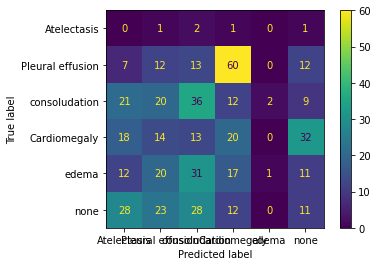

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pred = classification_model.predict(val_x)

print(pred.shape)
cmd = ConfusionMatrixDisplay((confusion_matrix(list(np.argmax(val_y, axis=1)), list(np.argmax(pred, axis=1)))), display_labels=['Atelectasis', 'Pleural effusion','consoludation' ,'Cardiomegaly','edema', 'none'])
cmd.plot()